In [1]:
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import copy
import random

In [2]:
#Data
MRPs=dict()
MRPs[0]=20
MRPs[1]=100
MRPs[2]=50
MRPs[3]=50
MRPs[4]=100
MRPs[5]=60
MRPs[6]=35
MRPs[7]=216
MRPs[8]=27
MRPs[9]=130
MRPs[10]=160
MRPs[11]=89
MRPs[12]=73
MRPs[13]=27
MRPs[14]=185
MRPs[15]=249
MRPs[16]=199
MRPs[17]=46
MRPs[18]=55
MRPs[19]=99
'''
MRPs['chocolate']=20
MRPs['shampoo']=100
MRPs['chips']=50
MRPs['pulses']=50
MRPs['apples']=100
MRPs['grapes']=60
MRPs['pepsi']=35
MRPs['bournvita']=216
MRPs['bread']=27
MRPs['jam']=130
MRPs['buscuits']=160
MRPs['butter']=89
MRPs['toothpaste']=73
MRPs['eggs']=27
MRPs['flour']=185
MRPs['peanut_butter']=249
MRPs['cheese']=199
MRPs['milk']=46
MRPs['yoghurt']=55
MRPs['muffins']=99
'''

no_shops=4
no_items=2

actions=range(no_shops)

reward_buying=50

#Bernoulli variable for each shop
bernoulli=np.random.rand(no_shops,no_items)

#Price bias for each shop
bias=np.random.normal(0,5,no_shops)

#Distance Matrix
a = np.random.uniform(1,10,(no_shops,no_shops))
distance_matrix = np.tril(a) + np.tril(a, -1).T
np.fill_diagonal(distance_matrix,0)

print 'Distance between shops'
print distance_matrix

Distance between shops
[[ 0.          3.1665332   3.20767632  2.72984277]
 [ 3.1665332   0.          4.98135473  8.94559068]
 [ 3.20767632  4.98135473  0.          8.95114536]
 [ 2.72984277  8.94559068  8.95114536  0.        ]]


In [3]:
def price_penalty(next_state):
    scaling=0.1
    shop=next_state[0]
    next_status=next_state[1]
    price=0
    for item_no in range(len(next_status)):
        if next_state[1][item_no]:
            price=price+np.random.normal(MRPs[item_no]+bias[shop],1)
        
    return -price*scaling

In [4]:
def distance_penalty(distance):
    return -distance

In [5]:
def availability_in_shop(current_state,next_state):
    old_status=current_state[1]
    new_status=next_state[1]
    next_shop=next_state[0]
    
    prob=1
    
    for item_no in range(len(old_status)):
        if old_status[item_no]==0:
            if new_status[item_no]==0:
                prob=prob*(1-bernoulli[next_shop][item_no])
            else:
                prob=prob*bernoulli[next_shop][item_no]
                
    return prob

In [6]:
def PVF(num_states,samples,k,state_space_enumeration):
    G = np.zeros((num_states,num_states))
    for sample in samples:
        G[state_space_enumeration[sample[0]]][state_space_enumeration[sample[3]]]+=1
    denominator = np.sum(G, axis = 1)
    P = np.zeros((num_states,num_states))
    for i in range(num_states):
        for j in range(num_states):
            if(denominator[i]!=0):
                P[i,j]=G[i,j]/denominator[i]
    evals, evecs = np.linalg.eigh(P)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[idx]
    perron_vec = evecs[-1]
    D = np.zeros((num_states,num_states))
    for i in range(num_states):
        D[i][i] = perron_vec[i]
    L = D - (D.dot(P)+P.T.dot(D))/2.0
    evals,evecs = np.linalg.eigh(L)
    idx = evals.argsort()[::-1]
    evals = evals[idx]
    evecs = evecs[idx]
    phi = np.array([evecs[i] for i in range(k)]).T
    print phi[0,:][np.newaxis].T.shape
    return phi


In [7]:
def LSPE(num_states,samples,phi,state_space_enumeration, alpha):
    r = np.zeros(phi.shape[1])[np.newaxis].T
    for k in range(len(samples)):
        C = np.zeros((phi.shape[1],phi.shape[1]))
        d = np.zeros(phi.shape[1])[np.newaxis].T
        for i in range(k):
            C+= phi[state_space_enumeration[samples[i][0]],:][np.newaxis].T.dot(phi[state_space_enumeration[samples[i][0]],:][np.newaxis])
            q = phi[state_space_enumeration[samples[i][0]],:][np.newaxis].dot(r) - alpha*phi[state_space_enumeration[samples[i][3]],:][np.newaxis].dot(r) + samples[i][2]/60.0
            d+= phi[state_space_enumeration[samples[i][0]],:][np.newaxis].T*q
        r_next = r - np.linalg.pinv(C).dot(d)
        if(all(i<0.1 for i in np.abs(r_next-r))):
            break
    return r

In [8]:
def sampling(policy, k):
    global state_space
    samples = []
    current_state = random.choice(state_space)
    for i in range(k):
        sample=[]
        next_state,reward=takeaction(current_state,policy[current_state])
        sample.append(current_state)
        sample.append(policy[current_state])
        sample.append(reward)
        samples.append(next_state)
        if(not all(i==0 for i in (next_state[1]-np.ones(no_items)))):
            current_state=next_state
        else:
            current_state=random.choice(state_space)
    return samples

In [9]:
def RPI():
    global state_space
    state_space_enumeration =dict()
    i=0
    for state in state_space:
        state_space_enumeration[state]=i
        i+=1
    nextpolicy = dict()
    policy=dict()
    for state in state_space:
        nextpolicy[state] = random.randint(0,no_shops)
        nextpolicy[state] = random.randint(0,no_shops)
    flag=True
    while(flag):
        flag = False
        policy = copy.deepcopy(nextpolicy)
        samples = sampling(policy,10000)
        phi = PVF(len(state_space),samples,20,state_space_enumeration)
        r = LSPE(len(state_space),samples,phi,state_space_enumeration,0.7)
        V = phi.dot(r)
        for state in state_space:
            P, nextpolicy[state] = T(V,state)
        for state in state_space:
            if(policy[state]!=nextpolicy[state]):
                flag=True

In [10]:
def M(shop_b,shop_a):
    temp=sum(sum(np.triu(distance_matrix)))
    temp2=(temp-distance_matrix[shop_b,shop_a])/((no_shops-1)*temp)
    return temp2

In [11]:
def T(V,current_state):
    alpha = 0.9
    min_action = sys.maxint
    min_V=float('inf')
    for action in actions:
        summ=0
        for next_state in state_space:
            if(P[(current_state,action,next_state)]!=0):
                summ += (-R[(current_state,action,next_state)]/500.0 + alpha*V[next_state])*P[(current_state,action,next_state)]
        # print summ
        if (summ<min_V):
            min_V=summ
            min_action=action
    return min_V,min_action

In [12]:
#Creating State Space
state_space=[]
all_possible_buying_statuses=list(itertools.product([0, 1], repeat=no_items))

for shop_no in range(no_shops):
    for buying_status in all_possible_buying_statuses:
        state=(shop_no,buying_status)
        state_space.append(state)

print 'State Space'
print len(state_space)

State Space
16


In [13]:
#Defining Transition Probabilities and Rewards
P=dict()
R=dict()

actions=range(no_shops)
for current_state, action, next_state in list(itertools.product(state_space,actions,state_space)):
    if current_state[1]==tuple(np.ones(no_items)):
        P[(current_state,action,next_state)]=0
        R[(current_state,action,next_state)]=None
        continue
    
    if action == current_state[0]: #action==current_shop
        if next_state[0]!=current_state[0]:
            P[(current_state,action,next_state)]=0
            R[(current_state,action,next_state)]=None
        else:
            P[(current_state,action,next_state)]=availability_in_shop(current_state,next_state)
            bought_items=sum(next_state[1])
            if bought_items>0:
                R[(current_state,action,next_state)]=bought_items*reward_buying+distance_penalty(distance_matrix[current_state[0]][next_state[0]])+price_penalty(next_state)
            else:
                R[(current_state,action,next_state)]=distance_penalty(distance_matrix[current_state[0]][next_state[0]])
    else:
        if next_state[0]==action:
            P[(current_state,action,next_state)]=0.9*availability_in_shop(current_state,next_state)
            bought_items=sum(next_state[1])
            if bought_items>0:
                R[(current_state,action,next_state)]=bought_items*reward_buying+distance_penalty(distance_matrix[current_state[0]][next_state[0]])+price_penalty(next_state)
            else:
                R[(current_state,action,next_state)]=distance_penalty(distance_matrix[current_state[0]][next_state[0]])
        else:
            P[(current_state,action,next_state)]=0.1*availability_in_shop(current_state,next_state)*M(next_state[0],current_state[0])
            bought_items=sum(next_state[1])
            if bought_items>0:
                R[(current_state,action,next_state)]=bought_items*reward_buying+distance_penalty(distance_matrix[current_state[0]][action]+distance_matrix[action][next_state[0]])+price_penalty(next_state)
            else:
                R[(current_state,action,next_state)]=distance_penalty(distance_matrix[current_state[0]][action]+distance_matrix[action][next_state[0]])
    
    #print "Next transition:"
    #print "Current State, Action, Next State, P, R"
    #print current_state, action, next_state, P[(current_state,action,next_state)],R[(current_state,action,next_state)]

In [14]:
def value_iteration(state_space):
    threshold = 1
    V = dict()
    next_V = dict()
    policy = dict()
    for state in state_space:
        V[state]=0.0
        next_V[state]=0.0
        policy[state]=-1
    flag = True
    # overflow = False
    while(flag):
        flag = False
        for current_state in state_space:
            next_V[current_state],policy[current_state]= T(V,current_state)
            print V[current_state]
            print next_V[current_state]
            if((abs(next_V[current_state]-V[current_state]))>threshold):
                flag = True
            V[current_state] = next_V[current_state]

    return V,policy

In [15]:
def takeaction(current_state,action):
    global P
    global R
    global state_space
    r = random.random()
    for next_state in state_space:
        if(r<=0):
            break
        r-=P[(current_state,action,next_state)]
    return next_state, R[(current_state,action,next_state)]

0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0))

0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.65

0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (0, 0))
(3, (0, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (1, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301

0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.49

0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (0, 0))
(3, (0, 0

0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (0, 1))
(0, (0, 1)) 3 (3, (0, 1))
(3, (0, 1)) 3 (0, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896

0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (0, 0))
(3, (0, 0)) 3 (0, (0, 1))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0

0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (0, 0))
(3, (0, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (0, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301

(3, (1, 0)) 3 (3, (0, 1))
(3, (0, 1)) 3 (2, (0, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 

0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (1, (1, 1))
0.0
-0.12

(0, (0, 0)) 3 (0, (1, 0))
(0, (1, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (1, (0, 1))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1,

-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.42

-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837

-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}

0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.7335

-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (

0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (3, (1, 0))
(3, (1,

-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (1, (0, 1))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.49

-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}

0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (0, 1))
(3, (0, 1)) 3 (3, (0, 1))
(3, (0, 1)) 3 (3, (0, 1))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507

{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (2, (0, 0))
(2, (0, 0)) 3 (2, (0, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0

Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (

-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.41

{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.7335

0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (1, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.30

-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}

-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (0, 1))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.49

(2, (1, 0)) 3 (1, (1, 0))
(1, (1, 0)) 3 (0, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 

0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (1, (0, 1))
Exception

(0, (0, 0)) 3 (2, (0, 0))
(2, (0, 0)) 3 (2, (0, 0))
(2, (0, 0)) 3 (2, (0, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1,

0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (1, 0))
(0, (1, 0)) 3 (2, (1, 0))
(2, (1,

-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.42

-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (2, (0, 1))
(2, (0, 1)) 3 (1, (0, 1))
(1, (0, 1)) 3 (2, (0, 1))
(2, (0, 1)) 3 (2, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.2173085113

0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0))

-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456

0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (1, (0, 0))
(1, (0, 0)) 3 (0, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0

-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.65

0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (1, 0))
Exception
0.0
-0.123144770431

0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-

0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (2, (1, 0))
(2, (1, 0)) 3 (2, (0, 1))
(2, (0, 1)) 3 (1, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0

(3, (1, 0)) 3 (1, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1,

{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (2, (1, 0))
(2, (1, 0)) 3 (2, (1, 0))
(2, (1, 0)) 3 (2, (1, 0))
(2, (1, 0)) 3 (1, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480

-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (0, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0

(3, (1, 0)) 3 (0, (0, 1))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1,

(3, (1, 0)) 3 (2, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1,

0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (0, (1, 0))
(0, (1, 0)) 3 (0, (1, 0))
(0, (1, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (1, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606

-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
Exception
0.0
-0.12

-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (2, (

0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (0, 0))
(3, (0, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (1, (1, 0))
Exception
0.0
-0.1231

0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (0, (0, 0)): 1, (2, (1, 0)): 2}
(0, (0, 0)) 3 (3, (1, 0))
(3, (1, 0)) 3 (2, (1, 0))
Exception
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0

(0, (0, 0)) 3 (3, (1, 1))
0.0
-0.123144770431
0.0
-0.233615406214
0.0
-0.361778502837
0.0
0
0.0
-0.217308511308
0.0
-0.428639109507
0.0
-0.497606000896
0.0
0
0.0
-0.306480840099
0.0
-0.655301368359
0.0
-0.733590837456
0.0
0
0.0
-0.417755453886
0.0
-0.855483032294
0.0
-0.934966117186
0.0
0
{(2, (1, 1)): 0, (0, (0, 1)): -0.23361540621419449, (0, (1, 0)): -0.36177850283712504, (1, (1, 0)): -0.49760600089568224, (3, (1, 0)): -0.93496611718565736, (3, (0, 0)): -0.4177554538864317, (2, (0, 1)): -0.65530136835948816, (1, (0, 0)): -0.21730851130826279, (2, (0, 0)): -0.30648084009903787, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): -0.42863910950719292, (3, (0, 1)): -0.85548303229435008, (0, (1, 1)): 0, (0, (0, 0)): -0.12314477043081237, (2, (1, 0)): -0.73359083745574771}
{(2, (1, 1)): 0, (0, (0, 1)): 1, (0, (1, 0)): 0, (1, (1, 0)): 1, (3, (1, 0)): 3, (3, (0, 0)): 2, (2, (0, 1)): 1, (1, (0, 0)): 0, (2, (0, 0)): 1, (3, (1, 1)): 0, (1, (1, 1)): 0, (1, (0, 1)): 0, (3, (0, 1)): 2, (0, (1, 1)): 0, (

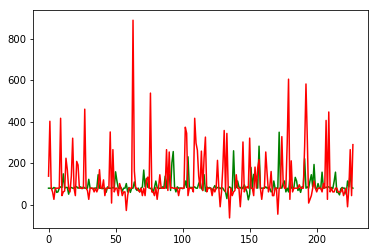

In [16]:
ran=[]
vi = []
c1=0
c2=0
for i in range(1000):
    try:
        J,policy = value_iteration(state_space)
        print J
        print policy
        summ1=0
        summ2=0
        current_state = (0, (0,0))
        while(current_state[1]!=(1,1)):
            next_state,reward = takeaction(current_state,random.randint(0,no_shops))
            print current_state,action,next_state
            summ1+=R[(current_state,action,next_state)]
            current_state=next_state

        current_state = (0, (0,0))
        while(current_state[1]!=(1,1)):
            next_state,reward = takeaction(current_state,policy[current_state])
            summ2+= R[(current_state,action,next_state)]
            current_state=next_state
        #print summ1,summ2
        c1+=summ1
        c2+=summ2
        ran.append(summ1)
        vi.append(summ2)
    except:
        print "Exception"
plt.plot(ran,label='Random',color = 'green')
plt.plot(vi,label='Value Iteration', color = 'red')
plt.show()

# RPI()
